<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/Vehicle_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports and Setup**

## **1.1. TensforFlow**

Change runtime to TPU if the code breakes on this line "import tensorflow as tf"

In [36]:
#TensorFlow
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import time
import pickle

# Define paths to the models stored on your Google Drive
tensorflow_model_path = '/content/drive/My Drive/models/tensorflow_vehicle_model.keras'
#fastai_model_path = '/content/drive/My Drive/models/fastai_vehicle_model.pkl'
base_split_dir = "/content/drive/My Drive/vehicles_split"
main_dir = "/content/drive/My Drive/Vehicles"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2. FastAI

In [37]:
#FastAI
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from fastai.vision.all import *
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import time
import pickle

# Define paths to the models stored on your Google Drive
#tensorflow_model_path = '/content/drive/My Drive/models/tensorflow_vehicle_model.keras'
fastai_model_path = '/content/drive/My Drive/models/fastai_vehicle_model.pkl'
base_split_dir = "/content/drive/My Drive/vehicles_split"
main_dir = "/content/drive/My Drive/Vehicles"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1.3. Custom model**

In [38]:
# Custom model-specific imports
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Define paths to your custom model
custom_model_path = '/content/drive/My Drive/models/custom_vehicle_model.keras'
custom_history_path = '/content/drive/My Drive/models/custom_model_history.pkl'

# **2. Data Preprocessing and Augmentation**

## **2.1. TensorFlow**

In [39]:
#TensorFlow
# TensorFlow-specific ImageDataGenerator setup
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define the categories you have for vehicle classification
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

# Prepare directories
base_split_dir = "/content/drive/My Drive/vehicles_split"
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_split_dir, "train"),
    target_size=(150, 150), batch_size=32, class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_split_dir, "val"),
    target_size=(150, 150), batch_size=32, class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_split_dir, "test"),
    target_size=(150, 150), batch_size=32, class_mode='categorical'
)

Found 3911 images belonging to 7 classes.
Found 838 images belonging to 7 classes.
Found 838 images belonging to 7 classes.


## ***2.2. FastAI***

In [40]:
# FastAI DataBlock setup
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=150, do_flip=True, max_rotate=20, max_zoom=1.1)
)

# Load data into DataLoaders
dls = dblock.dataloaders(base_split_dir, batch_size=32)

## **2.3. Custom model**

In [41]:
#same as for tensorflow

# **3. Model Loading and Building**

## **3.1. TensorFlow**

In [42]:
#Manually Rebuilding the Model Before Loading Weights

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Rebuild the architecture exactly as it was during training
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes as per your original categories
])


# Load the saved TensorFlow model from Google Drive
model = tf.keras.models.load_model(tensorflow_model_path)

# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 18913095 (72.15 MB)
Trainable params: 4198407 (16.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## **3.2. FastAI**

In [43]:
# Load the saved FastAI model from Google Drive
learn = load_learner(fastai_model_path)

# Check model summary
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## **3.3. Custom model**

In [44]:
# Rebuild the custom model architecture exactly as it was during training
custom_model = Sequential()

# First convolutional layer (with Batch Normalization)
custom_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D((2, 2)))

# Second convolutional layer (with Batch Normalization)
custom_model.add(Conv2D(128, (3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D((2, 2)))

# Third convolutional layer (with Batch Normalization)
custom_model.add(Conv2D(256, (3, 3), activation='relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPooling2D((2, 2)))

# Flattening the output for fully connected layers
custom_model.add(Flatten())

# Fully connected layer with fewer neurons and Dropout
custom_model.add(Dense(256, activation='relu'))
custom_model.add(Dropout(0.25))

# Output layer for classification (7 classes in your case)
custom_model.add(Dense(len(categories), activation='softmax'))

# Compile the custom model (same optimizer and loss used during training)
custom_optimizer = Adam(learning_rate=1e-4)
custom_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Load the saved custom TensorFlow model from Google Drive
custom_model.load_weights(custom_model_path)

# Check the custom model summary to verify it was loaded correctly
custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_3 (Bat  (None, 148, 148, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 batch_normalization_4 (Bat  (None, 72, 72, 128)       512       
 chNormalization)                                                
                                                      

# **4. Evaluation and Test Performance**

## **4.1. TensorFlow**

In [45]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator, steps=10)
print(f"Test accuracy: {test_acc * 100:.2f}%")

10/10 [==============================] - 5s 426ms/step - loss: 0.2292 - accuracy: 0.9156
Test accuracy: 91.56%


## **4.2. FastAI**

In [46]:
# Evaluate on test data
test_dl = dls.test_dl(get_image_files(os.path.join(base_split_dir, "test")))
results = learn.validate(dl=test_dl)
print(f"Validation Results: {results}")  # Print the full results to inspect

# Ensure `results` contains valid values before formatting
if results and results[0] is not None and results[1] is not None:
    print(f"Test loss: {results[0]:.4f}")
    print(f"Test accuracy: {results[1]:.4f}")
else:
    print(f"Unexpected results: {results}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Results: [None, None]
Unexpected results: [None, None]


## **4.3. Custom model**

In [47]:
# Evaluate the custom model on test data
custom_test_loss, custom_test_acc = custom_model.evaluate(test_generator, steps=10)  # Adjust steps as needed
print(f"Custom model test accuracy: {custom_test_acc * 100:.2f}%")

10/10 [==============================] - 4s 346ms/step - loss: 0.8118 - accuracy: 0.7656
Custom model test accuracy: 76.56%


# **5. Confusion Matrix**

## **5.1. TensorFlow**

27/27 [==============================] - 12s 439ms/step


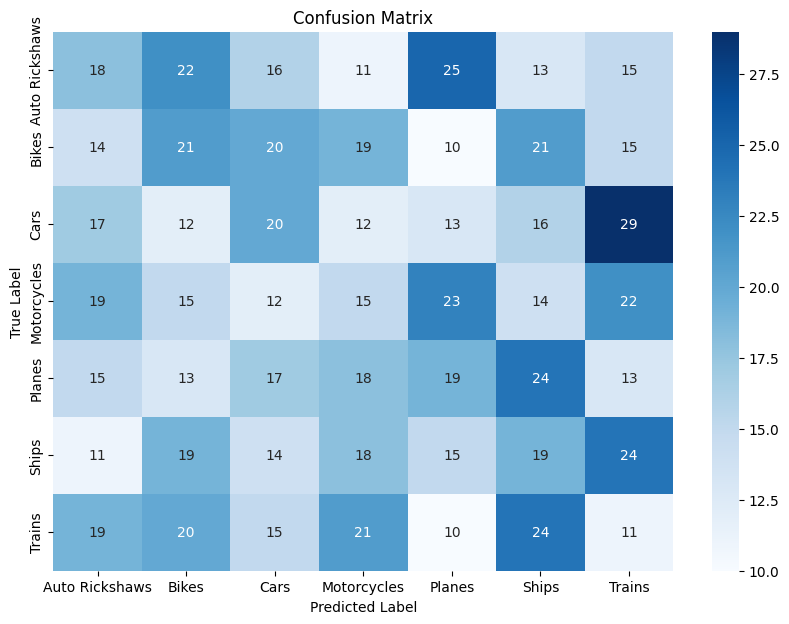

In [48]:
# Generate predictions on the test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## **5.2. FastAI**

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


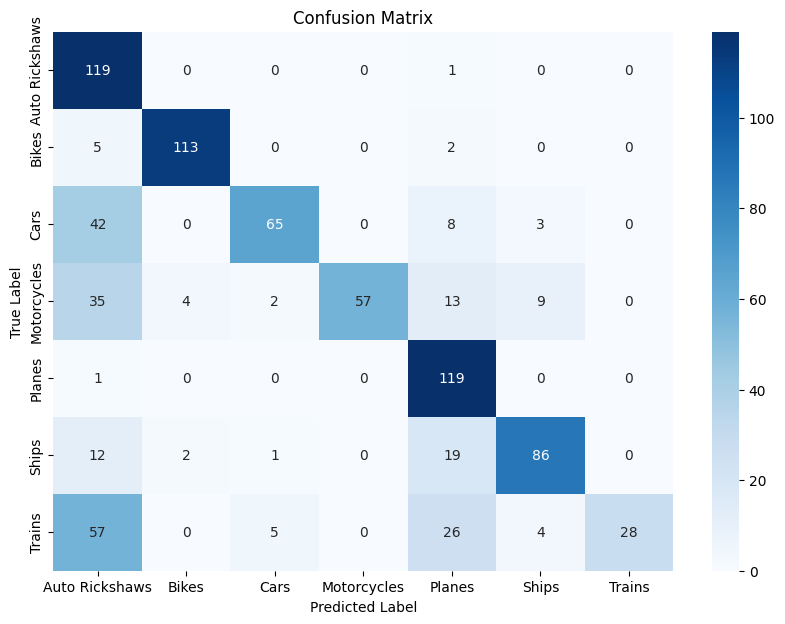

In [49]:
val_dl = dls.valid  # Using validation dataloader (which has labels)

# Generate predictions on the validation set
preds, targets = learn.get_preds(dl=val_dl)
predicted_classes = np.argmax(preds, axis=1)

# Convert the targets to numpy for compatibility with sklearn functions
true_classes = targets.numpy()

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

## **5.3. Custom model**

27/27 [==============================] - 10s 366ms/step


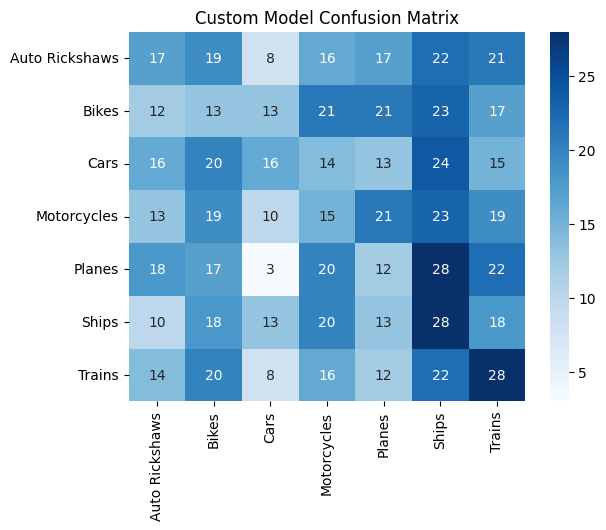

In [50]:
# Generate predictions on the test set
custom_predictions = custom_model.predict(test_generator, steps=test_steps_per_epoch)
custom_predicted_classes = np.argmax(custom_predictions, axis=1)

# Confusion Matrix for custom model
custom_conf_matrix = confusion_matrix(true_classes, custom_predicted_classes)
sns.heatmap(custom_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Custom Model Confusion Matrix')
plt.show()

# **6. Classification Report**

## **6.1. TensorFlow**

In [51]:
# Classification report for TensorFlow
report = classification_report(true_classes, predicted_classes, target_names=categories)
print(report)

                precision    recall  f1-score   support

Auto Rickshaws       0.44      0.99      0.61       120
         Bikes       0.95      0.94      0.95       120
          Cars       0.89      0.55      0.68       118
   Motorcycles       1.00      0.47      0.64       120
        Planes       0.63      0.99      0.77       120
         Ships       0.84      0.72      0.77       120
        Trains       1.00      0.23      0.38       120

      accuracy                           0.70       838
     macro avg       0.82      0.70      0.69       838
  weighted avg       0.82      0.70      0.69       838



## **6.2. FastAI**

In [52]:
# Classification report (precision, recall, f1-score)
report = classification_report(true_classes, predicted_classes, target_names=categories)
print( report)

                precision    recall  f1-score   support

Auto Rickshaws       0.44      0.99      0.61       120
         Bikes       0.95      0.94      0.95       120
          Cars       0.89      0.55      0.68       118
   Motorcycles       1.00      0.47      0.64       120
        Planes       0.63      0.99      0.77       120
         Ships       0.84      0.72      0.77       120
        Trains       1.00      0.23      0.38       120

      accuracy                           0.70       838
     macro avg       0.82      0.70      0.69       838
  weighted avg       0.82      0.70      0.69       838



## **6.3. Custom model**

In [53]:
custom_report = classification_report(true_classes, custom_predicted_classes, target_names=class_labels)
print("Custom Model Classification Report:\n", custom_report)

Custom Model Classification Report:
                 precision    recall  f1-score   support

Auto Rickshaws       0.17      0.14      0.15       120
         Bikes       0.10      0.11      0.11       120
          Cars       0.23      0.14      0.17       118
   Motorcycles       0.12      0.12      0.12       120
        Planes       0.11      0.10      0.10       120
         Ships       0.16      0.23      0.19       120
        Trains       0.20      0.23      0.22       120

      accuracy                           0.15       838
     macro avg       0.16      0.15      0.15       838
  weighted avg       0.16      0.15      0.15       838



# **7. Training History and Metrics Plot**

## **7.1. TensorFlow**

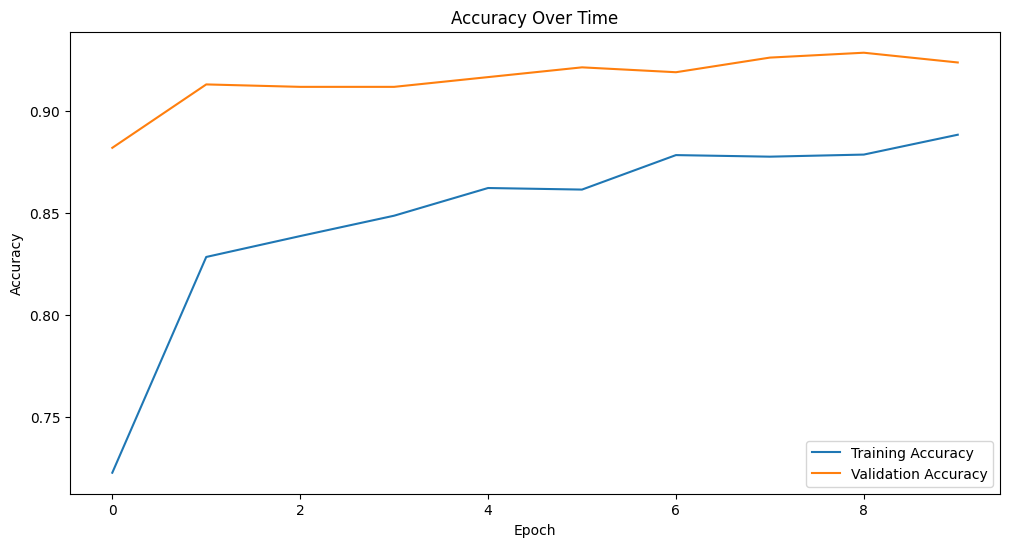

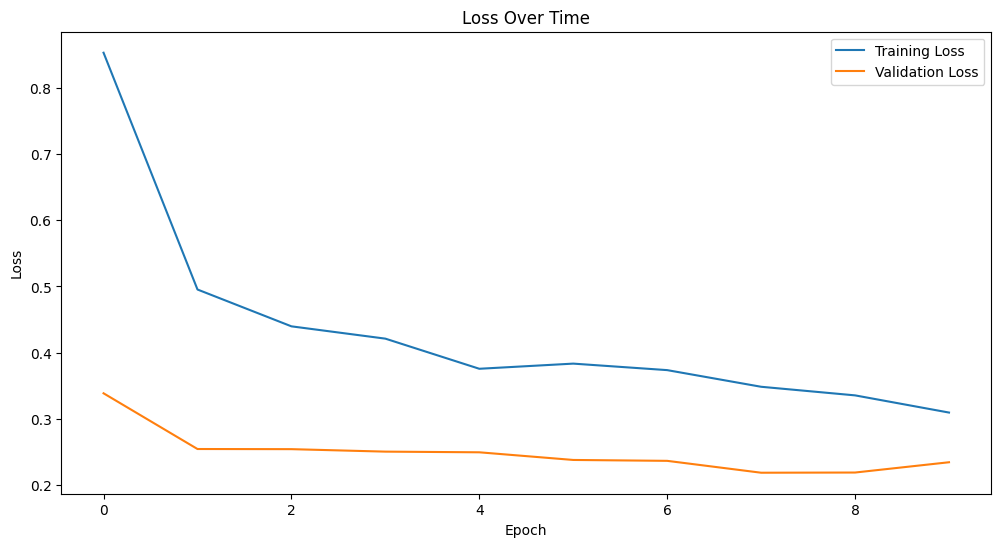

In [54]:
# Load and plot training history
history_path = '/content/drive/My Drive/models/model_history.pkl'
with open(history_path, 'rb') as file_pi:
    history = pickle.load(file_pi)

# Plot accuracy over time
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss over time (add this plot)
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **7.2. FastAI**

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


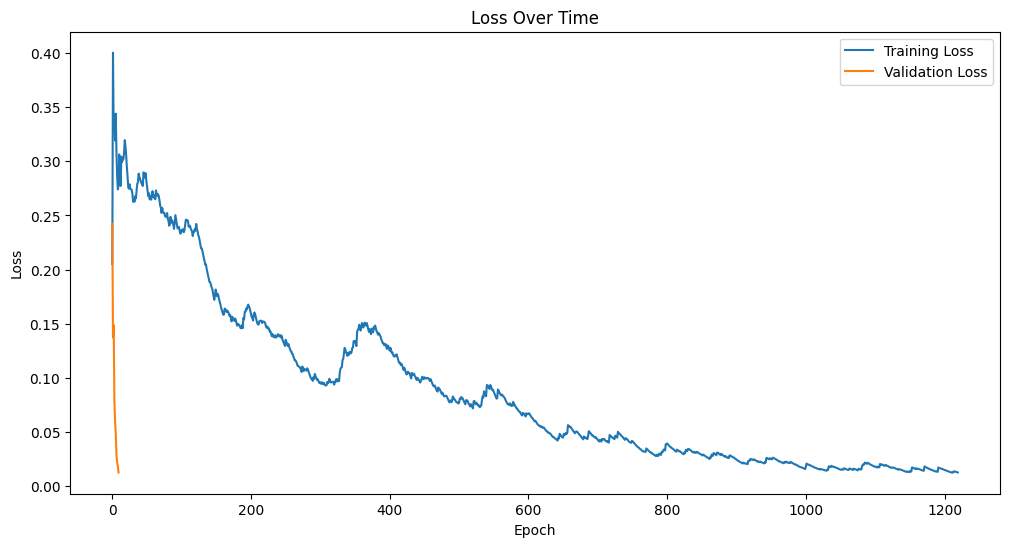

Accuracy Values: [0.1527385264635086, 0.16876675188541412, 0.196410670876503, 0.15271130204200745, 0.14383462071418762, 0.12237192690372467, 0.09570659697055817, 0.09444870054721832, 0.0931110680103302, 0.0879477709531784]


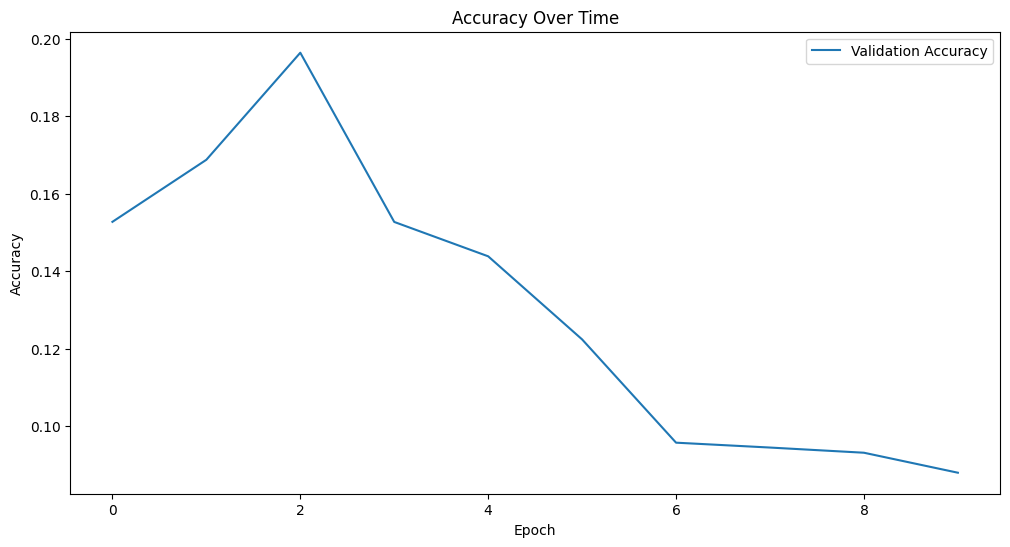

In [55]:
# Load the FastAI model history (for fastai_model_history.pkl)
history_path = '/content/drive/My Drive/models/fastai_model_history.pkl'
with open(history_path, 'rb') as file_pi:
    history = pickle.load(file_pi)

# Extract training and validation losses (No .item() required)
train_losses = history['train_loss']  # Already floats
valid_losses = history['valid_loss']  # Already floats

# Plot loss over epochs (FastAI)
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract accuracy values from history (No .item() required)
accuracy_values = history['accuracy']  # Already floats

print(f"Accuracy Values: {accuracy_values}")

# Plot accuracy over epochs (FastAI)
plt.figure(figsize=(12, 6))
plt.plot(accuracy_values, label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## **7.3. Custom model**

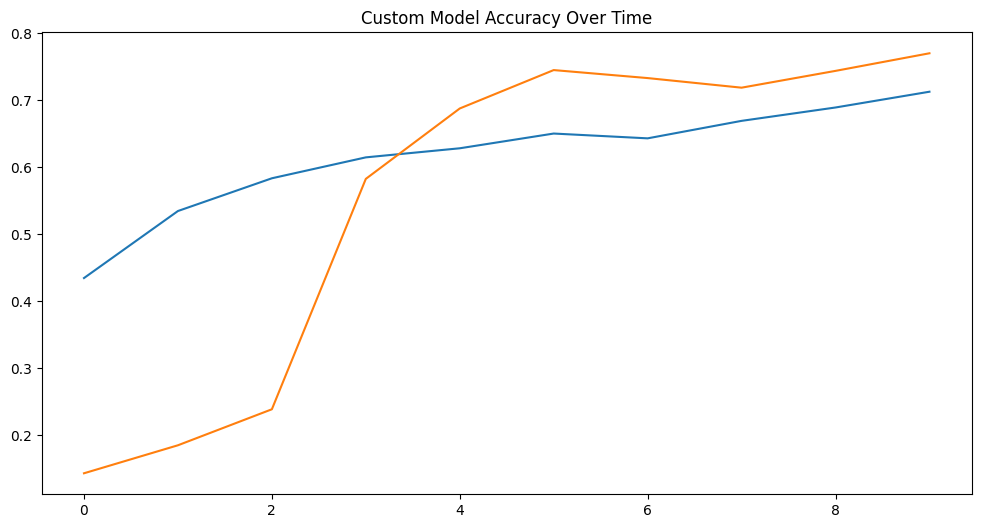

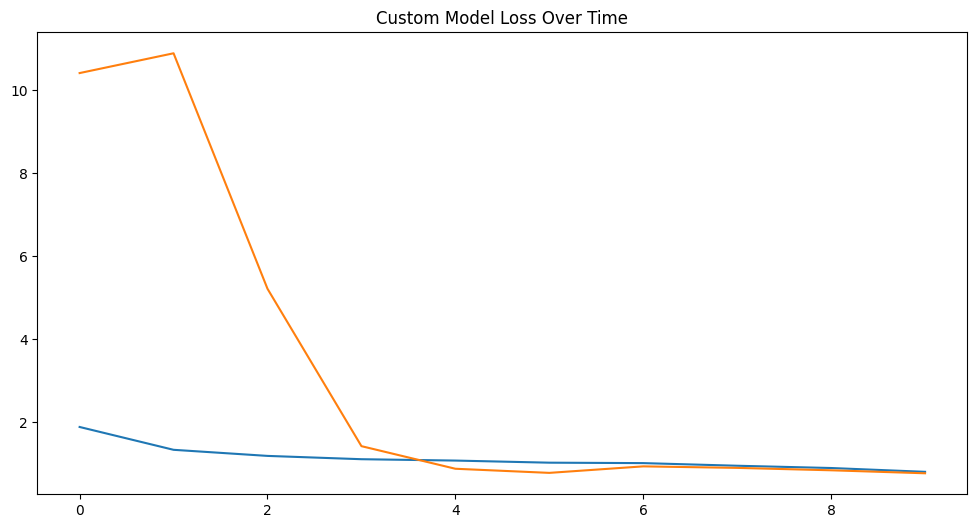

In [56]:
# Load and plot custom model training history
with open(custom_history_path, 'rb') as file_pi:
    custom_history = pickle.load(file_pi)

# Plot accuracy over epochs (Custom model)
plt.figure(figsize=(12, 6))
plt.plot(custom_history['accuracy'], label='Training Accuracy')
plt.plot(custom_history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom Model Accuracy Over Time')
plt.show()

# Plot loss over epochs (Custom model)
plt.figure(figsize=(12, 6))
plt.plot(custom_history['loss'], label='Training Loss')
plt.plot(custom_history['val_loss'], label='Validation Loss')
plt.title('Custom Model Loss Over Time')
plt.show()

# **8. Inference Timing**

## **8.1. TensorFlow**

In [57]:
# Timing inference
start_time = time.time()
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
end_time = time.time()
print(f'Total inference time: {end_time - start_time:.2f} seconds')

27/27 [==============================] - 12s 438ms/step
Total inference time: 12.93 seconds


## **8.2. FastAI**

In [58]:
# Timing inference
start_time = time.time()
preds, targets = learn.get_preds(dl=test_dl)
end_time = time.time()
print(f'Total inference time: {end_time - start_time:.2f} seconds')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total inference time: 6.54 seconds


## **8.3. Custom model**

In [59]:
# Inference time for custom model
start_time = time.time()
custom_predictions = custom_model.predict(test_generator, steps=test_steps_per_epoch)
end_time = time.time()

inference_time = end_time - start_time
print(f'Custom model total inference time: {inference_time:.2f} seconds')


27/27 [==============================] - 10s 370ms/step
Custom model total inference time: 10.14 seconds
